In [1]:
import numpy as np
from tqdm.notebook import tqdm

from neurodsp.sim import sim_oscillation, sim_powerlaw
from neurodsp.filt import filter_signal
from neurodsp.spectral import compute_spectrum

from fooof import FOOOF
from bycycle import Bycycle

from ndspflow import WorkFlow, Param

# WorkFlow Class

`WorkFlow` objects wrap analyses that are typically functionally oriented (e.g. scipy functions) into a unified object. This provides reproducible analyses, a unified interface for a variety of DSP packages and models, and memory/computational efficiency. This class consist of three types of nodes:

1. __Input__ : Defines the raw input numpy array, including simulations, reading BIDS structure, or custom classes or functions to read in raw binary data.
    
2. __Transformations__ : Defines the order of preprocessing operations used to manipulate the raw array input. Any function that accepts an y-array, and returns an y-array, with or without an x-array, are supported. This allows interfacing of signal processing packages, such as `scipy`, `numpy`, `mne`, `neurodsp`, etc. Examples: filtering, re-referencing, ICA, PSD, etc.

3. __Models__ : Defines the model class that is used to fit or extract values out of the transformed array. Models should be initialized and contain a `.fit` method that accepts array definitions. Examples: `fooof`, `bycycle`, `sklearn.svm.SVC`. Model initalization should follow Scikit-Learn specifications, outlined [here](https://scikit-learn.org/stable/developers/develop.html#instantiation).


__Forks__ : Forks refer to the splitting of the workflow into multiple streams. Forks may optionally have additional transforms (e.g. one model may want power spectra, whereas another requires time series).

__Param__ : In addition to forks, the `Param` class may be used to make workflow parameters iterable, such that the workflow is re-ran across a grid of unique parameters. This may be used in place or in addition to forks.

All steps in a `WorkFlow` are executed when the `.run()` method is called. 

In [2]:
# Settings
n_seconds = 10
fs = 1000
seeds = np.arange(4)

## 1. Input
When initializing a `WorkFlow` object, arbitary keyword arguments may be passed that are required by one of its sub-classes. In the case below, we want to set the seeds attributes, required by the `Simulation` sub-class accesed via the `.simulate()` method. X-axis values may be optionally defined here, if required by the model passed to the `.fit()` method.

Next we define the input array, here a series of simulations. Multiple simulation calls may be stacked to create the input array. Any simulation function may be used as long as a single array is returned. The way arrays are combined are defined by the `operator` argument. Alternatively, a single, custom simulation function could be constructed to combine arrays in arbitary ways. The general form for single simulation call follows: 

`.simulate(func, *args, operator, **kwargs)`

Alternatively, a bids directory may be loaded or a custom signal reader may be used (todo: see here).

In [3]:
# Iniatlize a simulation workflow with random seeds
wf = WorkFlow(seeds=seeds)

# Define np.array input
wf.simulate(sim_powerlaw, n_seconds, fs, exponent=-2)
wf.simulate(sim_oscillation, n_seconds, fs, freq=10, operator='add')
wf.simulate(sim_oscillation, n_seconds, fs, freq=20, operator='add')

## 2. Transform
The input array may transformed using any function, a single array should be returned for y-values (`return y`). Optionally, x-values may be returned (`return x, y`), such as when computing PSD from a time series. Transformation calls may also be stacked to define a series of sequential transformations (e.g. pre-processing steps, below a filter and spectral function are used). The `axis` argument is used for ndarrays with greater than two dimensions and specifies which axis to iterate over to apply the transform. The general form follows: 

`.transform(func, *args, axis=None, **kwargs)`.

Where `*args` and `**kwargs` are passed through to `func`.

In [4]:
# Transformations
wf.transform(filter_signal, fs, 'lowpass', 200, remove_edges=False) # -> returns y
wf.transform(compute_spectrum, fs) # -> returns x, y

## 3. Model

After loading or simulating data and applying transformations, models may be fit. Below a spectral model is fit, one per simulation.

In [5]:
wf.fit(FOOOF(verbose=False, max_n_peaks=1), (1, 100))

## 4. Execute

Lastly, the `WorkFlow` is executed in parallel using the `run` method.  Results are accesible via the `.results` attirbute. The order of models in `.results` maintains the in the same order as the `WorkFlow` was defined. Here the first index of `.results` refers to the simulation seed (in order of `seeds` above) and the second index refers to the order of the `.fit` calls above.

In [6]:
wf.run(n_jobs=1)
wf.results

array([<fooof.objs.fit.FOOOF object at 0x105e6a7d0>,
       <fooof.objs.fit.FOOOF object at 0x105e6a7d0>], dtype=object)

### Returning Model Attributes

The the `return_attrs` arguments is used to transfer any attribute in the model class to the results attribute of the WorkFlow class. This is more memory efficienct as copies of PSDs, time series, and all other model class attributes are not passed to the results attribute.

If `return_attrs` is a string or list of strings, these attribues are expected to exist in each model. A 2d list of return_attrs strings provides the greatest flexibility, pairing each list of attributes to each model.

In [7]:
# Execute workflow
attrs = [
    *[['peak_params_', 'aperiodic_params_', 'r_squared_']] * 2, # FOOOF attributes
]

# Rerun the workflow
wf.run(attrs=attrs)

wf.results

array([{'peak_params_': array([[19.99509317,  4.05606811,  1.99149562]]), 'aperiodic_params_': array([-0.66671812,  2.25376379]), 'r_squared_': 0.848126504332892},
       {'peak_params_': array([[20.00241904,  4.24312291,  2.00674921]]), 'aperiodic_params_': array([-0.6486932 ,  2.37561149]), 'r_squared_': 0.8505462522147984},
       {'peak_params_': array([[20.01927093,  3.77874737,  1.96829199]]), 'aperiodic_params_': array([-0.3886868 ,  2.28763031]), 'r_squared_': 0.8714572093222844},
       {'peak_params_': array([[20.04497602,  4.34117753,  2.05505677]]), 'aperiodic_params_': array([-0.80587386,  2.33826881]), 'r_squared_': 0.8402512604241956}],
      dtype=object)

# Advanced Usage

## 4. Forks
The `.fork(index)` method is used to split the workflow into sub-workflows, allowing unique transformation and/or models to be used with a common, inital array. The first `.fork(0)` called with a unique index argument creates a save state that may be restored later. Subsequent `.fork(0)` calls restores that state of the array at the time of the inital `.fork(0)`. 

New fork calls (e.g. `.fork(1)`) creates a new save state that can be later restored upon subsequent calls of `.fork(1)`. In general, a unique index passed to `.fork(ind)` creates a new save state, and an existing index restores the corresponding save state at the time of the first call. Below, we fork the workflow into sub-flows that end on two sets of `FOOOF` and `Bycycle` models. Note that the `.fit()` calls belows does not run the workflow and instead adds fitting the model to the call stack. Once the `WorkFlow` is complete, the `.run()` method is used to execute the workflow, as shown in the next section.

In [8]:
# Recreate the base simulation workflow all
#   forks below start with the array following the transform method call
wf = WorkFlow(seeds=seeds)

wf.simulate(sim_powerlaw, n_seconds, fs, exponent=-2)
wf.simulate(sim_oscillation, n_seconds, fs, freq=10, operator='add')
wf.simulate(sim_oscillation, n_seconds, fs, freq=20, operator='add')

wf.transform(filter_signal, fs, 'lowpass', 200, remove_edges=False)

In [9]:
# Create a fork that can be used to restore the state of the simulated arrays,
#   allowing modifications.
wf.fork(0)
wf.transform(compute_spectrum, fs)

# An nested fork allows various spectral models to be fit
#   here, max_n_peaks is varied.
wf.fork(1)
wf.fit(FOOOF(verbose=False, max_n_peaks=1), (1, 100))

wf.fork(1)
wf.fit(FOOOF(verbose=False, max_n_peaks=2), (1, 100))

In [10]:
# Restore that state to the simulations and fit a different model
wf.fork(0)

# Bycycle sub-workflows
wf.fork(2)
wf.fit(Bycycle(thresholds={'monotonicity': 0.5}), fs, (1, 30))

wf.fork(2)
wf.fit(Bycycle(thresholds={'monotonicity': 0.9}), fs, (1, 30))

In [11]:
# Run workflow
wf.run(n_jobs=1)
wf.results

array([[<fooof.objs.fit.FOOOF object at 0x166c36550>,
        <bycycle.objs.fit.Bycycle object at 0x166c1a010>]], dtype=object)

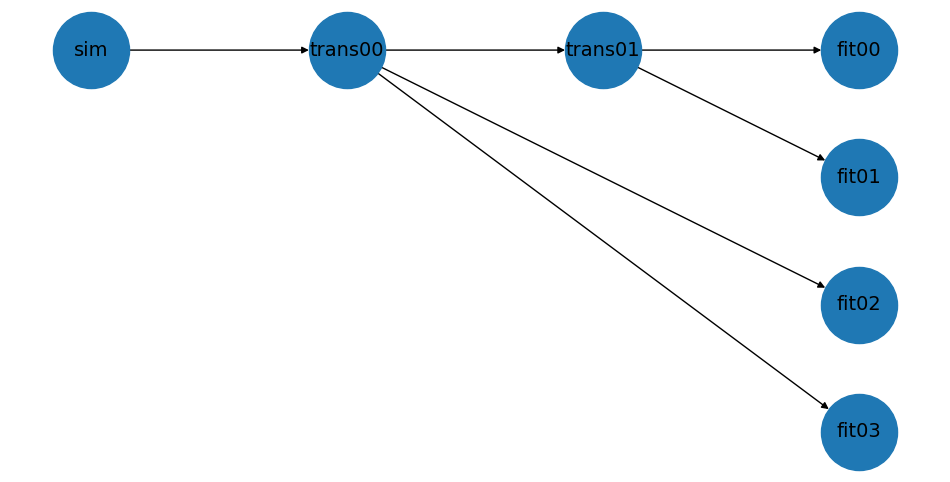

In [12]:
# Plot the workflow
wf.plot()

## WorkFlow Parameterization

The above workflow may be written more concisely with the `Param` class. This marks parameters that should be iterated over to create a grid of all combinations.

The use of `Param` with model initalization prevents type checking or parameter manipulations. Instead, type checking or computed parameters should instead be peformed at fit time, after the values of `Param` have been unpacked. To use `Param`, the model's init must only set parameters, similar to Sci-kit Learn's API requirements. This states that for custom classifiers or model, "there should be no logic, not even input validation, and the parameters should not be changed.". See [here](https://scikit-learn.org/stable/developers/develop.html#instantiation) for init specifications.

In [13]:
# Initialize
wf = WorkFlow(seeds=seeds)

# 1. Define np.array input
wf.simulate(sim_powerlaw, n_seconds, fs, exponent=-2)
wf.simulate(sim_oscillation, n_seconds, fs, freq=10, operator='add')
wf.simulate(sim_oscillation, n_seconds, fs, freq=20, operator='add')

# 2. Transform input
wf.transform(filter_signal, fs, 'lowpass', 200, remove_edges=False)

# 3. Compute PSD and fit
wf.fork(0)
wf.transform(compute_spectrum, fs)
wf.fit(FOOOF(verbose=False, max_n_peaks=Param([1, 2])), (1, 100))

# 4. Fit time domain
wf.fork(0)
wf.fit(
    Bycycle(thresholds=Param([
        {'monotonicity_threshold': 0.5}, 
        {'monotonicity_threshold': 0.9}
    ])),
    fs, (5, 25)
)

wf.run(n_jobs=1, parameterize=True)

print(wf.results.shape) # (n_simulations, n_models, n_params)

wf.results

/Users/ryanhammonds/projects/ndspflow/.env/lib/python3.11/site-packages/bycycle/objs/fit.py:31: UserWarning: 
                No burst detection thresholds are provided. This is not recommended. Please
                inspect your data and choose appropriate parameters for 'thresholds'.
                Default burst detection parameters are likely not well suited for your
                desired application.
                
  warnings.warn("""


(4, 2, 2)


array([[[<fooof.objs.fit.FOOOF object at 0x16252b010>,

       [[<fooof.objs.fit.FOOOF object at 0x166c80350>,

       [[<fooof.objs.fit.FOOOF object at 0x166e06790>,

       [[<fooof.objs.fit.FOOOF object at 0x166e32750>,
         <bycycle.objs.fit.Bycycle object at 0x166c37b90>]]], dtype=object)